# NBA player stats projection for upcoming 2020-21 season
In this notebook, I will project the statistics of each active player in the NBA for the upcoming 2020-21 season. To do this, I will use time series forecasting with ARIMA to project the per minute averages of each statistic based on past seasons. I will choose the ARIMA model with the lowest RMSE value for different values of p, d, q. This may lead to some overfitting because  we would usually want atleast 40 previous values in the time series data to train an ARIMA model, but I am curious to see what the forecasted statistics are for next season based on this approach.
<br>
<br>
There are some players who have only played in 1 previous season, or have gap years. This will affect the time series forecasting so I will remove these players from the list of players that will receive projections.

In [1]:
import pandas as pd
import numpy as np
from nba_api.stats.static import players
from nba_api.stats import endpoints
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from itertools import product
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import warnings
import time

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
#get all active players currently in the NBA
active_players_df = pd.DataFrame(players.get_active_players())

active_players_df[['PROJECTED_LOWER_PTS_PER_MIN','PROJECTED_PTS_PER_MIN','PROJECTED_UPPER_PTS_PER_MIN',
                  'PROJECTED_LOWER_ORB_PER_MIN','PROJECTED_ORB_PER_MIN','PROJECTED_UPPER_ORB_PER_MIN',
                  'PROJECTED_LOWER_DRB_PER_MIN','PROJECTED_DRB_PER_MIN','PROJECTED_UPPER_DRB_PER_MIN',
                  'PROJECTED_LOWER_TRB_PER_MIN','PROJECTED_TRB_PER_MIN','PROJECTED_UPPER_TRB_PER_MIN',
                  'PROJECTED_LOWER_AST_PER_MIN','PROJECTED_AST_PER_MIN','PROJECTED_UPPER_AST_PER_MIN',
                  'PROJECTED_LOWER_FG_PER_MIN','PROJECTED_FG_PER_MIN','PROJECTED_UPPER_FG_PER_MIN',
                  'PROJECTED_LOWER_FGM_PER_MIN','PROJECTED_FGM_PER_MIN','PROJECTED_UPPER_FGM_PER_MIN',
                  'PROJECTED_LOWER_FGA_PER_MIN','PROJECTED_FGA_PER_MIN','PROJECTED_UPPER_FGA_PER_MIN',
                  'PROJECTED_LOWER_FG3M_PER_MIN','PROJECTED_FG3M_PER_MIN','PROJECTED_UPPER_FG3M_PER_MIN',
                  'PROJECTED_LOWER_FG3A_PER_MIN','PROJECTED_FG3A_PER_MIN','PROJECTED_UPPER_FG3A_PER_MIN',
                  'PROJECTED_LOWER_FTM_PER_MIN','PROJECTED_FTM_PER_MIN','PROJECTED_UPPER_FTM_PER_MIN',
                  'PROJECTED_LOWER_FTA_PER_MIN','PROJECTED_FTA_PER_MIN','PROJECTED_UPPER_FTA_PER_MIN',
                  'PROJECTED_LOWER_TOV_PER_MIN','PROJECTED_TOV_PER_MIN','PROJECTED_UPPER_TOV_PER_MIN',
                  'PROJECTED_LOWER_MINS_PER_GAME','PROJECTED_MINS_PER_GAME','PROJECTED_UPPER_MINS_PER_GAME']] = np.NaN

In [4]:
active_players_df.head()

,id,full_name,first_name,last_name,is_active,PROJECTED_LOWER_PTS_PER_MIN,PROJECTED_PTS_PER_MIN,PROJECTED_UPPER_PTS_PER_MIN,PROJECTED_LOWER_ORB_PER_MIN,PROJECTED_ORB_PER_MIN,PROJECTED_UPPER_ORB_PER_MIN,PROJECTED_LOWER_DRB_PER_MIN,PROJECTED_DRB_PER_MIN,PROJECTED_UPPER_DRB_PER_MIN,PROJECTED_LOWER_TRB_PER_MIN,PROJECTED_TRB_PER_MIN,PROJECTED_UPPER_TRB_PER_MIN,PROJECTED_LOWER_AST_PER_MIN,PROJECTED_AST_PER_MIN,PROJECTED_UPPER_AST_PER_MIN,PROJECTED_LOWER_FG_PER_MIN,PROJECTED_FG_PER_MIN,PROJECTED_UPPER_FG_PER_MIN,PROJECTED_LOWER_FGM_PER_MIN,PROJECTED_FGM_PER_MIN,PROJECTED_UPPER_FGM_PER_MIN,PROJECTED_LOWER_FGA_PER_MIN,PROJECTED_FGA_PER_MIN,PROJECTED_UPPER_FGA_PER_MIN,PROJECTED_LOWER_FG3M_PER_MIN,PROJECTED_FG3M_PER_MIN,PROJECTED_UPPER_FG3M_PER_MIN,PROJECTED_LOWER_FG3A_PER_MIN,PROJECTED_FG3A_PER_MIN,PROJECTED_UPPER_FG3A_PER_MIN,PROJECTED_LOWER_FTM_PER_MIN,PROJECTED_FTM_PER_MIN,PROJECTED_UPPER_FTM_PER_MIN,PROJECTED_LOWER_FTA_PER_MIN,PROJECTED_FTA_PER_MIN,PROJECTED_UPPER_FTA_PER_MIN,PROJECTED_LOWER_TOV_PER_MIN,PROJECTED_TOV_PER_MIN,PROJECTED_UPPER_TOV_PER_MIN,PROJECTED_LOWER_MINS_PER_GAME,PROJECTED_MINS_PER_GAME,PROJECTED_UPPER_MINS_PER_GAME
0,203500,Steven Adams,Steven,Adams,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1628389,Bam Adebayo,Bam,Adebayo,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,200746,LaMarcus Aldridge,LaMarcus,Aldridge,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1629734,Kyle Alexander,Kyle,Alexander,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1629638,Nickeil Alexander-Walker,Nickeil,Alexander-Walker,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#function to pull season by season stats for each player
def get_player_data(id):
    data = endpoints.playerdashboardbyyearoveryear.PlayerDashboardByYearOverYear(player_id = id)
    
    df = data.by_year_player_dashboard.get_data_frame()
    df = df.reindex(index=df.index[::-1]).reset_index(drop=1)

    df['MPG'] = df['MIN'] / df['GP']

    df['PTS_PER_MIN'] = df['PTS'] / df['MIN']
    df['ORB_PER_MIN'] = df['OREB'] / df['MIN']
    df['DRB_PER_MIN'] = df['DREB'] / df['MIN']
    df['TRB_PER_MIN'] = (df['DREB'] + df['OREB']) / df['MIN']
    df['AST_PER_MIN'] = df['AST'] / df['MIN']
    df['FG_PER_MIN'] = df['FGM'] / df['MIN']
    df['FGM_PER_MIN'] = df['FGM'] / df['MIN']
    df['FGA_PER_MIN'] = df['FGA'] / df['MIN']
    df['FG3M_PER_MIN'] = df['FG3M'] / df['MIN']
    df['FG3A_PER_MIN'] = df['FG3A'] / df['MIN']
    df['FTM_PER_MIN'] = df['FTM'] / df['MIN']
    df['FTA_PER_MIN'] = df['FTA'] / df['MIN']
    df['TOV_PER_MIN'] = df['TOV'] / df['MIN']
    df['MINS_PER_GAME'] = df['MIN'] / df['GP']

#cleans up rows where player played for multiple teams in the same season
    df.drop((df[df['TEAM_ID'] == -1].index - 1).values, inplace=True)
    df.drop((df[df['TEAM_ID'] == -1].index - 2).values, inplace=True)

    b = df['GROUP_VALUE'].iloc[0]
    e = df['GROUP_VALUE'].iloc[-1]
    df.index = pd.period_range(b[0:2] + b[-2:], e[0:2] + e[-2:], freq='Y')

    return(df)

In [6]:
get_player_data(203500)

,GROUP_SET,GROUP_VALUE,TEAM_ID,TEAM_ABBREVIATION,MAX_GAME_DATE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,CFID,CFPARAMS,MPG,PTS_PER_MIN,ORB_PER_MIN,DRB_PER_MIN,TRB_PER_MIN,AST_PER_MIN,FG_PER_MIN,FGM_PER_MIN,FGA_PER_MIN,FG3M_PER_MIN,FG3A_PER_MIN,FTM_PER_MIN,FTA_PER_MIN,TOV_PER_MIN,MINS_PER_GAME
2014,By Year,2013-14,1610612760,OKC,2014-04-16T00:00:00,81,59,22,0.728,1197.323333,93,185,0.503,0,0,0.000,79,136,0.581,142,190,332,43,71,40,57,13,203,125,265,57,947.9,1,0,1,1,1,1,7,7,7,7,2,6,2,7,7,4,7,7,7,7,7,6,7,1,3,7,7,6,7,7,1,264,2013-14,14.781770,0.221327,0.118598,0.158687,0.277285,0.035913,0.077673,0.077673,0.154511,0.000000,0.000000,0.065981,0.113587,0.059299,14.781770
2015,By Year,2014-15,1610612760,OKC,2015-04-15T00:00:00,70,37,33,0.529,1770.550000,217,399,0.544,0,2,0.000,103,205,0.502,199,324,523,66,99,38,86,27,222,186,537,46,1536.6,10,0,6,7,4,7,5,6,6,6,2,2,2,6,4,6,6,4,6,5,4,7,2,2,6,6,6,7,6,5,1,264,2014-15,25.293571,0.303296,0.112394,0.182994,0.295388,0.037277,0.122561,0.122561,0.225354,0.000000,0.001130,0.058174,0.115783,0.055915,25.293571
2016,By Year,2015-16,1610612760,OKC,2016-04-12T00:00:00,80,54,26,0.675,2014.388333,261,426,0.613,0,0,0.000,114,196,0.582,219,314,533,62,84,42,89,31,223,195,636,478,1677.6,6,0,2,2,3,2,4,5,5,2,2,6,2,5,6,3,4,5,5,6,6,5,1,3,7,5,5,1,5,6,1,264,2015-16,25.179854,0.315729,0.108718,0.155879,0.264596,0.030779,0.129568,0.129568,0.211479,0.000000,0.000000,0.056593,0.097300,0.041700,25.179854
2017,By Year,2016-17,1610612760,OKC,2017-04-12T00:00:00,80,47,33,0.588,2389.365000,374,655,0.571,0,1,0.000,157,257,0.611,281,332,613,86,146,89,78,44,195,266,905,195,2124.6,16,0,2,3,4,4,3,3,3,5,2,5,2,2,3,1,3,3,3,4,1,3,3,5,2,3,3,4,3,4,1,264,2016-17,29.867062,0.378762,0.117604,0.138949,0.256554,0.035993,0.156527,0.156527,0.274131,0.000000,0.000419,0.065708,0.107560,0.061104,29.867062
2018,By Year,2017-18,1610612760,OKC,2018-04-11T00:00:00,76,43,33,0.566,2486.851667,448,712,0.629,0,2,0.000,160,286,0.559,384,301,685,88,128,92,78,46,215,278,1056,321,2392.0,28,0,5,5,4,6,2,2,2,1,2,2,2,1,2,5,2,6,2,3,3,2,3,6,5,1,2,3,2,2,1,264,2017-18,32.721732,0.424633,0.154412,0.121037,0.275449,0.035386,0.180147,0.180147,0.286306,0.000000,0.000804,0.064338,0.115005,0.051471,32.721732
2019,By Year,2018-19,1610612760,OKC,2019-04-10T00:00:00,80,47,33,0.588,2669.258333,481,809,0.595,0,2,0.000,146,292,0.500,391,369,760,124,135,117,76,50,204,278,1108,389,2650.0,29,0,2,3,4,4,1,1,1,3,2,2,2,3,1,7,1,2,1,2,2,1,5,7,4,1,1,2,1,1,1,264,2018-19,33.365729,0.415097,0.146483,0.138241,0.284723,0.046455,0.180200,0.180200,0.303080,0.000000,0.000749,0.054697,0.109394,0.050576,33.365729
2020,By Year,2019-20,1610612760,OKC,2020-08-14T00:00:00,63,40,23,0.635,1680.510000,283,478,0.592,1,3,0.333,117,201,0.582,207,376,583,146,94,51,67,32,122,209,684,149,1862.6,22,0,7,6,2,3,6,4,4,4,1,1,1,4,5,2,5,1,4,1,5,4,6,4,1,4,4,5,4,3,1,264,2019-20,26.674762,0.407019,0.123177,0.223742,0.346918,0.086878,0.168401,0.168401,0.284437,0.000595,0.001785,0.069622,0.119607,0.055935,26.674762


In [13]:
%%time
#get list of all players that only played in 1 season or has gap years
lst = []
for i in active_players_df['id']:
    try:
        if len(get_player_data(i)) == 1:
            lst.append(i)
    except ValueError:
        lst.append(i)
    time.sleep(2)
lst

Wall time: 2min 56s


[1629738,
 1629044,
 1629673,
 1629645,
 1629008,
 204001,
 1629729,
 1629629,
 1629675,
 1629244,
 203460,
 1629620,
 1629676,
 201565,
 1629677,
 203960,
 1629678,
 1629621,
 1629735,
 1629346,
 1629034]

In [14]:
#update active_players_df by removing ids in lst
active_players_df = active_players_df[~active_players_df['id'].isin(lst)].reset_index(drop=1)

In [7]:
#funtion to fit ARIMA model based on specified values of p, d, q
def test_arima(p,d,q, endog, data_ind):
    try:
        mod = sm.tsa.SARIMAX(endog,order=(p,d,q), seasonal_order=(0,0,0,0))
        res = mod.fit()
        
        conf = res.get_forecast('2021').summary_frame(alpha=0.1)
        
        value = pd.Series([conf.values[0][0]])
        value_cleaned = endog.append(value).reset_index(drop=1)
        
        fitted = pd.Series(res.fittedvalues[1:].values)
        rmse = mean_squared_error(value_cleaned[1:-1].reset_index(drop=1), fitted, squared=False)
        return(rmse)
    except:
        np.NaN

#function to test all values of q between 0 and 5, d between 0 and 1, and q between 0 to 13 and returns the RMSE value
def get_best_params(endog, data_ind):
    p = list(range(0,5))
    d = [0,1]
    q = list(range(0,13))

    pdq_df = pd.DataFrame(product(p, d, q), columns=['P', 'D', 'Q'])
    pdq_df['RMSE'] = np.nan
    
    for i in range(0,len(pdq_df)):
        pdq_df['RMSE'].iloc[i] = test_arima(p=pdq_df.iloc[i][0], d=pdq_df.iloc[i][1], q=pdq_df.iloc[i][2], endog=endog, data_ind=data_ind)
    min_RMSE = pdq_df[pdq_df['RMSE'] == pdq_df['RMSE'].min()]
    return(min_RMSE)


def build_model(p, d, q, endog):
    mod = sm.tsa.SARIMAX(endog,order=(p,d,q), seasonal_order=(0,0,0,0))
    res = mod.fit()
    conf = res.get_forecast('2021').summary_frame(alpha=0.1)
    return(conf)

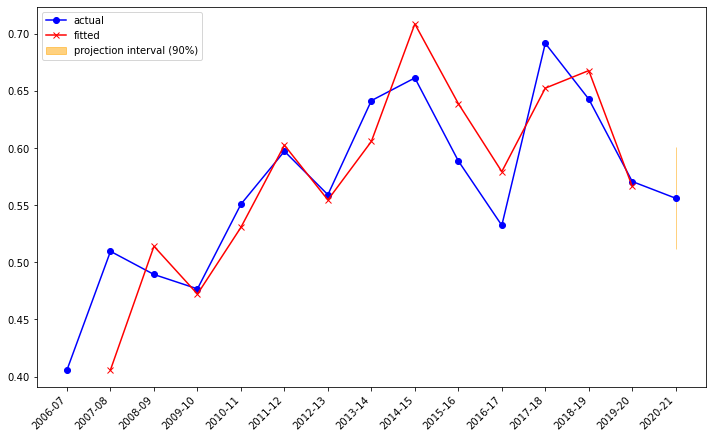

In [9]:
best_pdq = get_best_params(get_player_data(200746)['PTS_PER_MIN'], get_player_data(200746)['GROUP_VALUE'])

endog = get_player_data(200746)['PTS_PER_MIN']
# endog.plot(figsize=(15, 5))

mod = sm.tsa.SARIMAX(endog, 
                     order=(best_pdq['P'].values[0],
                            best_pdq['D'].values[0],
                            best_pdq['Q'].values[0]), 
                     seasonal_order=(0,0,0,0))
res = mod.fit()
conf = res.get_forecast('2021').summary_frame(alpha=0.1)

years = pd.Series(['2020-21'])
years_cleaned = get_player_data(200746)['GROUP_VALUE'].append(years).reset_index(drop=1)
vals = pd.Series([conf.values[0][0]])
vals_cleaned = get_player_data(200746)['PTS_PER_MIN'].append(vals).reset_index(drop=1)

fitted = pd.Series(res.fittedvalues[1:].values)


plt.figure(figsize=(12,7))
plt.plot(years_cleaned, vals_cleaned, marker="o", color='blue',label='actual')
plt.xticks(rotation=45, ha='right');
plt.fill_between('2020-21', 
                 conf.values[0][2], 
                 conf.values[0][3], 
                 color='orange', 
                 alpha=.5, 
                 label='projection interval (90%)');
plt.plot(years_cleaned[1:-1], fitted, marker='x', color='red', label='fitted')
plt.legend(loc='upper left')

This plot shows the ARIMA model with the lowest RMSE value for the PTS_PER_MIN variable. As you can see, there is a lot of overfitting, so the projection may be inaccurate. I added an upper and lower bound projection which represent the upper and lower bound of a 90% confidence interval.

In [ ]:
%%time
projection_cols = ['PTS_PER_MIN','ORB_PER_MIN','DRB_PER_MIN','TRB_PER_MIN','AST_PER_MIN','FG_PER_MIN',
                   'FGM_PER_MIN','FGA_PER_MIN','FG3M_PER_MIN','FG3A_PER_MIN','FTM_PER_MIN','FTA_PER_MIN',
                   'TOV_PER_MIN','MINS_PER_GAME']

group_value = ['GROUP_VALUE']

#get the parameters p, d, q with the lowest RMSE values for each statistic
for i in range(0,len(active_players_df)):
    player_df = get_player_data(active_players_df.iloc[i]['id'])
    
    for j in range(0,len(projection_cols)):
        
        min_RMSE = get_best_params(player_df[projection_cols[j]], player_df[group_value])
        projection = build_model(p=min_RMSE['P'].values[0], 
                                 d=min_RMSE['D'].values[0], 
                                 q=min_RMSE['Q'].values[0], 
                                 endog=player_df[projection_cols[j]])
        active_players_df[('PROJECTED_' + projection_cols[j])].iloc[i] = projection['mean'][0]
        active_players_df[('PROJECTED_LOWER_' + projection_cols[j])].iloc[i] = projection['mean_ci_lower'][0]
        active_players_df[('PROJECTED_UPPER_' + projection_cols[j])].iloc[i] = projection['mean_ci_upper'][0]
    
        
    active_players_df.to_csv('C:/Users/andre/OneDrive/Desktop/Python Datasets/player projections/player projections.xlsx')
        
    time.sleep(2)

# Analysis of projections
I will only use the projected stats instead of the upper or lower values for now and see how everything looks.<br>
There are additional stats such as Field Goals Missed and Free Throws Missed that are not in my data, but these values can be derived from Projected Field Goals Attempted - Projected Field Goals Made.

In [38]:
#import player projections
df2 = pd.read_excel('C:/Users/andre/OneDrive/Desktop/Python Datasets/player projections/player projections.xlsx').drop(columns='Unnamed: 0', axis=1)

df2['PROJECTED_FGMI_PER_MIN'] = df2['PROJECTED_FGA_PER_MIN'] - df2['PROJECTED_FGM_PER_MIN']
df2['PROJECTED_FTMI_PER_MIN'] = df2['PROJECTED_FTA_PER_MIN'] - df2['PROJECTED_FTM_PER_MIN']

df2.head()

,id,full_name,first_name,last_name,is_active,PROJECTED_LOWER_PTS_PER_MIN,PROJECTED_PTS_PER_MIN,PROJECTED_UPPER_PTS_PER_MIN,PROJECTED_LOWER_ORB_PER_MIN,PROJECTED_ORB_PER_MIN,PROJECTED_UPPER_ORB_PER_MIN,PROJECTED_LOWER_DRB_PER_MIN,PROJECTED_DRB_PER_MIN,PROJECTED_UPPER_DRB_PER_MIN,PROJECTED_LOWER_TRB_PER_MIN,PROJECTED_TRB_PER_MIN,PROJECTED_UPPER_TRB_PER_MIN,PROJECTED_LOWER_AST_PER_MIN,PROJECTED_AST_PER_MIN,PROJECTED_UPPER_AST_PER_MIN,PROJECTED_LOWER_FG_PER_MIN,PROJECTED_FG_PER_MIN,PROJECTED_UPPER_FG_PER_MIN,PROJECTED_LOWER_FGM_PER_MIN,PROJECTED_FGM_PER_MIN,PROJECTED_UPPER_FGM_PER_MIN,PROJECTED_LOWER_FGA_PER_MIN,PROJECTED_FGA_PER_MIN,PROJECTED_UPPER_FGA_PER_MIN,PROJECTED_LOWER_FG3M_PER_MIN,PROJECTED_FG3M_PER_MIN,PROJECTED_UPPER_FG3M_PER_MIN,PROJECTED_LOWER_FG3A_PER_MIN,PROJECTED_FG3A_PER_MIN,PROJECTED_UPPER_FG3A_PER_MIN,PROJECTED_LOWER_FTM_PER_MIN,PROJECTED_FTM_PER_MIN,PROJECTED_UPPER_FTM_PER_MIN,PROJECTED_LOWER_FTA_PER_MIN,PROJECTED_FTA_PER_MIN,PROJECTED_UPPER_FTA_PER_MIN,PROJECTED_LOWER_TOV_PER_MIN,PROJECTED_TOV_PER_MIN,PROJECTED_UPPER_TOV_PER_MIN,PROJECTED_LOWER_MINS_PER_GAME,PROJECTED_MINS_PER_GAME,PROJECTED_UPPER_MINS_PER_GAME,PROJECTED_FGMI_PER_MIN,PROJECTED_FTMI_PER_MIN
0,203500,Steven Adams,Steven,Adams,True,0.356201,0.398421,0.440642,0.112878,0.116702,0.120526,0.229669,0.255782,0.281895,0.309341,0.331223,0.353105,0.106555,0.118742,0.130929,0.153015,0.173449,0.193882,0.153015,0.173449,0.193882,0.256276,0.290886,0.325496,-0.000370,0.000000,0.000370,0.000113,0.001186,0.002259,0.062298,0.065208,0.068119,0.103356,0.106595,0.109834,0.046627,0.050672,0.054717,23.137616,27.765245,32.392874,0.117437,0.041387
1,1628389,Bam Adebayo,Bam,Adebayo,True,0.442655,0.532206,0.621757,0.040957,0.051242,0.061527,0.192201,0.229728,0.267255,0.268666,0.304434,0.340202,0.152962,0.198482,0.244003,0.193043,0.216430,0.239817,0.193043,0.216430,0.239817,0.254354,0.338193,0.422032,-0.001053,0.000437,0.001926,0.004937,0.007334,0.009731,0.072414,0.092581,0.112748,0.114621,0.140192,0.165764,0.098944,0.107154,0.115363,29.674983,39.611345,49.547707,0.121762,0.047611
2,200746,LaMarcus Aldridge,LaMarcus,Aldridge,True,0.507246,0.554158,0.601071,0.042911,0.060082,0.077254,0.116129,0.144435,0.172741,0.188684,0.221699,0.254715,0.066078,0.080343,0.094608,0.195592,0.212656,0.229720,0.195592,0.212656,0.229720,0.436184,0.474774,0.513364,-0.000318,0.005614,0.011546,0.020176,0.035313,0.050450,0.100117,0.115861,0.131605,0.154084,0.170212,0.186341,0.030045,0.039374,0.048704,24.835858,29.870425,34.904993,0.262118,0.054352
3,1628960,Grayson Allen,Grayson,Allen,True,0.167180,0.346922,0.526664,0.004677,0.011135,0.017592,0.009922,0.107172,0.204423,0.014585,0.118307,0.222029,0.052108,0.072376,0.092644,0.159725,0.162846,0.165968,0.159725,0.162846,0.165968,-0.038223,0.195673,0.429570,0.075285,0.079335,0.083386,-0.018783,0.111354,0.241491,-0.102493,0.000156,0.102804,-0.143540,-0.006288,0.130965,-0.071389,0.004197,0.079783,5.827327,18.907105,31.986883,0.032827,-0.006443
4,1628386,Jarrett Allen,Jarrett,Allen,True,0.408085,0.418442,0.428800,0.076081,0.100333,0.124585,0.177598,0.238035,0.298473,0.357337,0.385505,0.413673,0.040070,0.058161,0.076251,0.158848,0.159845,0.160842,0.158848,0.159845,0.160842,0.200419,0.218949,0.237478,-0.003342,-0.002830,-0.002317,0.012683,0.022364,0.032044,0.075113,0.092224,0.109335,0.115111,0.144534,0.173956,0.021361,0.032147,0.042932,19.260103,26.433942,33.607781,0.059104,0.052310


Here is the scoring format for each stat in my specific league:<br>
<pre>
FGMI (Field Goals Missed) = -0.5
FTMI (Free Throws Missed) = -0.75
3PM (3 Pointers Made)     = +0.75
OREB (Offensive Rebounds) = +1.75
DREB (Defensive Rebounds) = +1.25
AST (Assists)             = +2
STL (Steals)              = +2.5
BLK (Blocks)              = +2.5
TO (Turnovers)            = -2
PTS (Points)              = +1
</pre>
To calculate the projected fantasy points per game for each player, I will multiply: <pre>projected fantasy points per game = sum[(projected per minute statistic) * (projected minutes per game) * (scoring value)]</pre>
It turns out that I forgot to include the steals and blocks per minute stats. I will leave that out of this analysis to save time because of how long it took to compute all of the projections.

In [50]:
df2['PROJECTED_FPPG_PER_GAME'] = ((df2['PROJECTED_FGMI_PER_MIN'] * -0.5) +
                                  (df2['PROJECTED_FTMI_PER_MIN'] * -0.75) +
                                  (df2['PROJECTED_FG3M_PER_MIN'] * 0.75) +
                                  (df2['PROJECTED_ORB_PER_MIN'] * 1.75) +
                                  (df2['PROJECTED_DRB_PER_MIN'] * 1.25) +
                                  (df2['PROJECTED_AST_PER_MIN'] * 2) +
                                  (df2['PROJECTED_TOV_PER_MIN'] * -2) +
                                  (df2['PROJECTED_PTS_PER_MIN'] * 1)) * df2['PROJECTED_MINS_PER_GAME']

In [56]:
pd.options.display.float_format = '{:20,.2f}'.format

df2.sort_values(by='PROJECTED_FPPG_PER_GAME', ascending=False)[['id','full_name','PROJECTED_FPPG_PER_GAME']].head(10)

,id,full_name,PROJECTED_FPPG_PER_GAME
210,1628388,TJ Leaf,"4,097,896,794,149,136,554,167,367,630,848.00"
20,1628366,Lonzo Ball,"22,712,104,979,322,980.00"
32,1628395,Jordan Bell,"4,985,728,574,245,116.00"
323,1628372,Dennis Smith Jr.,"897,617,487,186,657.00"
5,1628443,Kadeem Allen,"819,996,944,592,167.50"
228,1628412,Frank Mason,"660,331,051,836,591.12"
10,203507,Giannis Antetokounmpo,48.14
335,1626157,Karl-Anthony Towns,46.67
188,203999,Nikola Jokic,46.41
99,1629029,Luka Doncic,45.24


There seems to be something wrong with the projects for the players in the first 6 rows. I will remove these rows from my dataset.

In [70]:
df2.sort_values(by='PROJECTED_FPPG_PER_GAME', ascending=False)[['id','full_name','PROJECTED_FPPG_PER_GAME']].iloc[6:].head(20)

,id,full_name,PROJECTED_FPPG_PER_GAME
10,203507,Giannis Antetokounmpo,48.14
335,1626157,Karl-Anthony Towns,46.67
188,203999,Nikola Jokic,46.41
99,1629029,Luka Doncic,45.24
141,201935,James Harden,45.00
173,202681,Kyrie Irving,43.63
316,1627783,Pascal Siakam,42.99
98,203915,Spencer Dinwiddie,42.80
181,2544,LeBron James,42.27
1,1628389,Bam Adebayo,39.43


This list makes somewhat sense other than players such as Spencer Dinwiddie and Ish Smith. They are more of role players rather than the best player on their team, so projections this high can be viewed as false.<br>
<br>
With the absence of blocks and steals, defensive minded players such as Anthony Davis, Jusuf Nurkic, and Andre Drummond might appear lower than they should.
<br>
<br>
I am also surprised at how low Russell Westbrook is on the projections. I would have expected him to be in the top 20. This can be due to the missing steals and blocks categories, or the ARIMA models chosen are overfitting on the historical statistics.

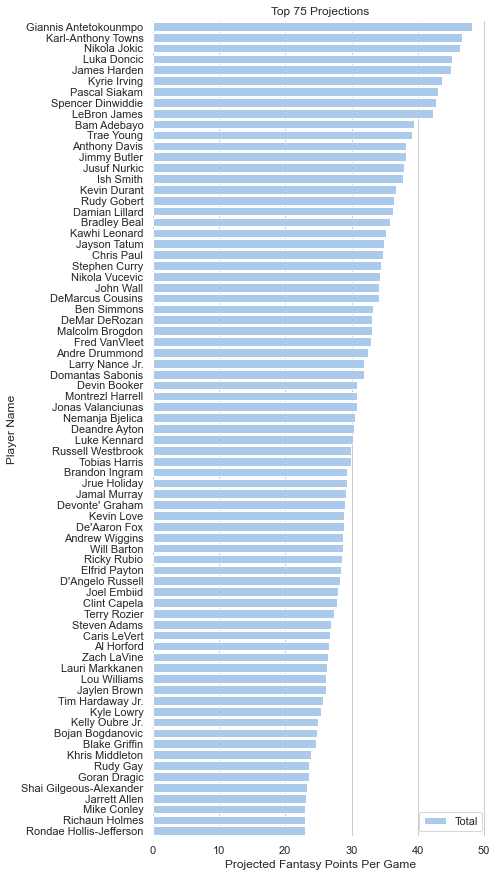

In [76]:
import seaborn as sns
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Load the example car crash dataset

sns.set_color_codes("pastel")
sns.barplot(y="full_name", x="PROJECTED_FPPG_PER_GAME", data=df2.sort_values(by='PROJECTED_FPPG_PER_GAME', ascending=False)[['id','full_name','PROJECTED_FPPG_PER_GAME']].iloc[6:].head(75),
            label="Total", color="b")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
plt.ylabel('Player Name')
plt.xlabel('Projected Fantasy Points Per Game')
plt.title('Top 75 Projections')
sns.despine(left=True, bottom=True)

Here is the top 75 players based on their projected fantasy points per game. I am curious how this list compares to the actual rankings at the end of next season. The absence of blocks and steals may have a large impact on the ranking of players in my projections. I will be sure to compare my projections with the actual data at the end of next season and I will remove the block and steals categories from the actual data as well to make it a fair comparison.